# Evn

In [1]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [2]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
!nvidia-smi

Thu Jan 28 02:39:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 입력 및 Vocab

In [4]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [5]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [6]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [7]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [8]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [10]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units=5)
output_11 = rnn_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.01514973 -0.09326975  0.01840017  0.00075474 -0.06511912]], shape=(1, 5), dtype=float32)


In [11]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [12]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True)
output_12 = rnn_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.02564576  0.0414134  -0.00366702  0.00832783 -0.02934231]
  [ 0.03541386 -0.03377459  0.02673792 -0.05788843  0.07016172]
  [-0.06389105  0.11147652  0.06913166 -0.04338427 -0.09603856]
  [-0.00451822 -0.02526462 -0.04234821 -0.16096973  0.13076156]
  [-0.15742928  0.05024348  0.13930199 -0.00516977 -0.11125721]
  [ 0.05772443  0.06315199  0.03761887 -0.11873235  0.24143264]
  [-0.22489886  0.0802756   0.02204562 -0.07525431 -0.12735648]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [13]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units=5, return_state=True)
output_13, fw_h_13 = rnn_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[ 0.01325146  0.01543665  0.01574939 -0.08289386 -0.10723302]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.01325146  0.01543665  0.01574939 -0.08289386 -0.10723302]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [15]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = rnn_14(hidden)  # (bs, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[ 0.00590874  0.0028001   0.0163781   0.01286094  0.00768337]
  [-0.05468912  0.02358556  0.07046149  0.00917335 -0.02554081]
  [-0.04945466  0.04766351  0.12698157  0.1021547  -0.03881431]
  [-0.03869173 -0.01949337  0.01132951  0.17425625  0.04203815]
  [ 0.07497236 -0.09957771  0.00447285  0.12770155  0.08036561]
  [-0.04466121 -0.12347331  0.03201293 -0.00349205  0.07580476]
  [-0.02579907 -0.12706423  0.12158288 -0.02453106  0.00580525]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[-0.02579907 -0.12706423  0.12158288 -0.02453106  0.00580525]], shape=(1, 5), dtype=float32)


## init hidden state

In [16]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.04806692, -0.15309517, -0.0424258 ,  0.05481382,  0.01750821]],
      dtype=float32)>

In [17]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.01864117,  0.19930609,  0.05907857,  0.02298412,
         -0.01138971],
        [-0.03834724, -0.04197052, -0.0968001 , -0.15910685,
          0.07223615],
        [-0.10761679,  0.00871815,  0.20008802, -0.03018681,
         -0.07608694],
        [ 0.02127854,  0.13606344, -0.01810385, -0.13007013,
          0.1703177 ],
        [-0.24753802,  0.01320222,  0.01703671, -0.07128724,
         -0.10669363],
        [ 0.02976049, -0.0258163 ,  0.16307406, -0.06508531,
          0.27215904],
        [-0.20114374,  0.23087487,  0.00498026, -0.02518472,
         -0.09764127]]], dtype=float32)>

In [18]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state=[fw_h_13])  # (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545615, -0.01660539,  0.01871963,  0.0433761 , -0.07521319]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545615, -0.01660539,  0.01871963,  0.0433761 , -0.07521319]],
       dtype=float32)>]

In [19]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.10664171, -0.08244667,  0.1256673 ,  0.02146415,
           0.01014192],
         [-0.10115883, -0.04596755,  0.20433494,  0.08314066,
          -0.05288311],
         [-0.13136418, -0.0306072 ,  0.19138892,  0.2147751 ,
          -0.01812209],
         [-0.03037347, -0.13687159,  0.07587608,  0.27524197,
           0.06485065],
         [ 0.02995035, -0.23832367,  0.02546421,  0.17624031,
           0.13718492],
         [-0.04318405, -0.2651414 ,  0.1044561 , -0.00325901,
           0.09102661],
         [-0.11092176, -0.23854555,  0.18744901, -0.03936188,
           0.01659928]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.11092176, -0.23854555,  0.18744901, -0.03936188,  0.01659928]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [20]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.00060078  0.00327611 -0.0104871   0.00319098 -0.00986872]], shape=(1, 5), dtype=float32)


In [23]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [24]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00109647  0.003973    0.00491607  0.00434578 -0.00010082]
  [ 0.00348979  0.00353155  0.00068605 -0.00139282  0.00037354]
  [ 0.00375388  0.00900979  0.00461504  0.00242298  0.00143028]
  [ 0.00433982  0.00436818  0.00329972  0.00142956  0.0009454 ]
  [ 0.00166688  0.00650878  0.00713827  0.00487696  0.0003925 ]
  [ 0.00533907  0.00496987  0.00216444 -0.00129159  0.00064027]
  [ 0.00699196  0.00437341  0.0025941  -0.0012665   0.00110581]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [25]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor([[ 0.01270817  0.00426247 -0.0069476  -0.00339907  0.00714148]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.01270817  0.00426247 -0.0069476  -0.00339907  0.00714148]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.02524674  0.00855356 -0.0138775  -0.00675538  0.01418355]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [26]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[-0.00454985  0.00470479  0.00206735  0.00485496  0.00213091]
  [ 0.00073271  0.00211161  0.00372537 -0.00451934  0.0078272 ]
  [-0.00545445  0.00725455  0.00914777 -0.00209438  0.0153161 ]
  [ 0.00060309  0.00399206  0.0055583  -0.00447689  0.01326353]
  [-0.00357282  0.00748128  0.00660762  0.00078497  0.01259337]
  [ 0.0018736   0.00390511  0.00752793 -0.00803026  0.01602855]
  [ 0.00511028  0.0013761   0.00686375 -0.01015518  0.01634174]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.00511028  0.0013761   0.00686375 -0.01015518  0.01634174]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.01022531  0.00275458  0.01357382 -0.02040049  0.03267182]], shape=(1, 5), dtype=float32)


## init hidden state

In [27]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.0020528 ,  0.00396284, -0.0106103 ,  0.00434631, -0.00752067]],
      dtype=float32)>

In [28]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.0043316 ,  0.00310752,  0.00760197, -0.00407275,
          0.01107558],
        [ 0.00866989,  0.00187653,  0.00078309, -0.00855344,
          0.00838333],
        [ 0.00828202,  0.00715887,  0.0031396 , -0.0034293 ,
          0.00734903],
        [ 0.00824108,  0.00263226,  0.00090744, -0.00356296,
          0.00535129],
        [ 0.0048789 ,  0.00502058,  0.00424512,  0.00081109,
          0.00388957],
        [ 0.00803183,  0.00377398, -0.00090499, -0.00467007,
          0.00347771],
        [ 0.00918326,  0.00340134, -0.00046838, -0.00401122,
          0.0033771 ]]], dtype=float32)>

In [29]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_14])  # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01629294,  0.00591714, -0.00872038, -0.00532763,  0.01147515]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01629294,  0.00591714, -0.00872038, -0.00532763,  0.01147515]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03236625,  0.01188779, -0.01742421, -0.01059045,  0.02278331]],
       dtype=float32)>]

In [30]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.00068827,  0.00454898,  0.00819552, -0.00373686,
           0.01476663],
         [ 0.00371387,  0.00105553,  0.00936129, -0.01141357,
           0.01750989],
         [-0.00327902,  0.00567202,  0.01424038, -0.00781723,
           0.02265327],
         [ 0.00221132,  0.00222131,  0.01007294, -0.00916907,
           0.01882247],
         [-0.00244258,  0.00562747,  0.01064324, -0.00302774,
           0.01677139],
         [ 0.00268327,  0.00214192,  0.01116523, -0.01099788,
           0.01912111],
         [ 0.00566882, -0.00024219,  0.01003959, -0.01256068,
           0.01861349]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00566882, -0.00024219,  0.01003959, -0.01256068,  0.01861349]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01134585, -0.00048479,  0.0198376 , -0.02525334,  0.03723406]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [58]:
# GRU
gru_11 = tf.keras.layers.GRU(units=5)
output_11 = gru_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[-0.00952872  0.0011493   0.00012684 -0.00472678  0.00678847]], shape=(1, 5), dtype=float32)


In [59]:
# GRU weights
weights = gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape)  # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [60]:
# (return_sequences=True)
gru_12 = tf.keras.layers.GRU(units=5, return_sequences=True)
output_12 = gru_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 0.00209076  0.00560161 -0.00471563  0.00727398  0.01130388]
  [ 0.01583657  0.00831309 -0.00986343 -0.01620096 -0.00137196]
  [ 0.02173552  0.02303349 -0.01912488 -0.01201358  0.00504119]
  [ 0.01161161  0.01330828 -0.00880405 -0.00552785 -0.00367691]
  [ 0.0080651   0.01362299 -0.00934814  0.00392584  0.00777433]
  [ 0.01893892  0.01316231 -0.01256129 -0.01834666 -0.00413333]
  [ 0.01709346  0.01204462 -0.01158602 -0.01434767 -0.00630387]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [61]:
# (return_state=True)
gru_13 = tf.keras.layers.GRU(units=5, return_state=True)
output_13, fw_h_13 = gru_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.01570416  0.01135815 -0.00871262  0.00577182  0.00942964]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01570416  0.01135815 -0.00871262  0.00577182  0.00942964]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [62]:
# (return_sequences=True, return_state=True)
gru_14 = tf.keras.layers.GRU(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = gru_14(hidden)  # (bs, seq, units * 2), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[ 0.00028504  0.0006304   0.0074043   0.00683885  0.00259142]
  [-0.01264585  0.00250173  0.01535526 -0.00134975 -0.01786473]
  [-0.01594889  0.0048013   0.0284403   0.01483398 -0.01784761]
  [-0.00786046 -0.00278563  0.01283271  0.00921691 -0.00929069]
  [-0.00334764 -0.00247018  0.01543869  0.01319363 -0.00212411]
  [-0.01447569 -0.00028358  0.0203354   0.00276837 -0.02026125]
  [-0.01042191 -0.00155272  0.01716563  0.00234447 -0.01541868]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[-0.01042191 -0.00155272  0.01716563  0.00234447 -0.01541868]], shape=(1, 5), dtype=float32)


## init hidden state

In [63]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00956579,  0.00128171,  0.00014419, -0.00483497,  0.00681631]],
      dtype=float32)>

In [64]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00337173,  0.00641246,  0.00194466,  0.00808158,
          0.00438964],
        [ 0.01307858,  0.0094354 , -0.00746648, -0.01585663,
         -0.00439411],
        [ 0.02037938,  0.02390679, -0.01845155, -0.01181228,
          0.00371837],
        [ 0.01096878,  0.01387838, -0.00874911, -0.00538945,
         -0.0042471 ],
        [ 0.00777163,  0.0139684 , -0.00946513,  0.00402124,
          0.00752717],
        [ 0.01880739,  0.01335822, -0.01269173, -0.01828686,
         -0.00423728],
        [ 0.0170369 ,  0.0121543 , -0.01168843, -0.01430953,
         -0.0063484 ]]], dtype=float32)>

In [65]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01557792,  0.01178773, -0.00880749,  0.00649354,  0.00964441]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01557792,  0.01178773, -0.00880749,  0.00649354,  0.00964441]],
       dtype=float32)>]

In [66]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.00366216, -0.00082746,  0.01842395,  0.01055231,
          -0.00471432],
         [-0.0142117 ,  0.00093493,  0.02219389,  0.00169904,
          -0.02162134],
         [-0.01659076,  0.00332939,  0.03256711,  0.01699261,
          -0.01981094],
         [-0.00815126, -0.00402046,  0.01534394,  0.01062127,
          -0.01030191],
         [-0.00350276, -0.00343188,  0.0169602 ,  0.01407368,
          -0.00261517],
         [-0.01457922, -0.00098786,  0.02126795,  0.00330453,
          -0.02047644],
         [-0.01048922, -0.00205314,  0.01774576,  0.00266149,
          -0.0154876 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01048922, -0.00205314,  0.01774576,  0.00266149, -0.0154876 ]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [31]:
# bi rnn
# rnn_11 = tf.keras.layers.SimpleRNN(units=5)
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[ 0.01439055 -0.00074061  0.05117337 -0.0614779   0.00071227 -0.04819945
   0.02131286 -0.07948016 -0.00761658  0.04756698]], shape=(1, 10), dtype=float32)


In [32]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [33]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[-0.02111003  0.00364892 -0.01972594  0.00738589  0.0270774
   -0.05295384  0.16371438  0.03707304  0.03730908  0.07100099]
  [ 0.03405284 -0.00386749  0.08036513 -0.07829983  0.02092756
   -0.11284347  0.07547235  0.05216053  0.09302414  0.00028423]
  [-0.05437502  0.00801885 -0.07441045 -0.01932782  0.11035191
   -0.01275165  0.11196847  0.03334352  0.1077451   0.01637834]
  [ 0.03114799 -0.0629967   0.03383521 -0.09730414 -0.03951274
   -0.08757096  0.04359969  0.00733783  0.04863334 -0.00398718]
  [ 0.00311044  0.00878339 -0.13552791  0.06107867  0.02503214
   -0.00371345  0.07929843 -0.00140559  0.07846046 -0.02594825]
  [ 0.0703609   0.06722736  0.14856404 -0.1142449  -0.04551705
   -0.02511359  0.00737033 -0.03484119  0.05690842 -0.03410771]
  [-0.1538529  -0.02566531 -0.10163427  0.07767908  0.07455868
   -0.00910433 -0.00697496 -0.00082089  0.03058841 -0.0188344 ]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [34]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[ 0.07033627  0.10363517 -0.07253242  0.0577006   0.003049    0.09142406
   0.0043132   0.00246825  0.05289203  0.09165204]], shape=(1, 10), dtype=float32)
tf.Tensor([[ 0.07033627  0.10363517 -0.07253242  0.0577006   0.003049  ]], shape=(1, 5), dtype=float32)
tf.Tensor([[0.09142406 0.0043132  0.00246825 0.05289203 0.09165204]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [35]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[ 0.01781428  0.00233035  0.00493044  0.01907692 -0.00949217
    0.01808425 -0.04471127  0.10663959  0.02962003 -0.03498914]
  [ 0.04765073 -0.06443542 -0.06335938  0.02084118  0.00482429
    0.01195303 -0.04146964  0.02687017  0.06460515 -0.09760992]
  [ 0.09544633 -0.06172202 -0.00910548  0.13583428 -0.05219428
   -0.04498133 -0.05486111 -0.00165277  0.07459234 -0.01098083]
  [ 0.10702922 -0.13896568 -0.02943574  0.08746909  0.02068268
   -0.03699304  0.00568229  0.04023036 -0.00790851 -0.01595732]
  [ 0.1373085  -0.07020189  0.07732433  0.13641788 -0.03618027
    0.00068002 -0.05798889  0.00739134  0.0083633   0.00359668]
  [ 0.20536894 -0.15935428 -0.05823239  0.06345509  0.0532646
   -0.01001511  0.00534733 -0.01126779  0.00333041 -0.03075181]
  [ 0.20643203 -0.05204797  0.04417092  0.18773907 -0.05972262
    0.00390072 -0.00775527  0.00361878 -0.0115671   0.00767985]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.20643203 -0.05204797  0.04417092  0.18773907 -0.05

## init hidden state

In [36]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.018684  , -0.02716644,  0.14060928, -0.16790637, -0.041441  ,
        -0.01828708,  0.06248701, -0.06600416,  0.01901113,  0.1694574 ]],
      dtype=float32)>

In [37]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14])

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.01553212,  0.21728408,  0.07904401,  0.11573804,
          0.15713914, -0.05642826,  0.19136219, -0.07269356,
          0.00828761,  0.10352951],
        [-0.16085975, -0.03202166,  0.19571625, -0.20103173,
          0.14310226, -0.20457566,  0.03520649,  0.05222965,
          0.08840341, -0.06876825],
        [-0.028433  , -0.23863102, -0.17029038, -0.09084308,
          0.16909084,  0.05144431,  0.17813681,  0.02458563,
          0.08797046, -0.06323954],
        [ 0.27841124, -0.01727993, -0.07382844, -0.12045861,
         -0.04806555, -0.04442339, -0.04521081,  0.04964798,
          0.10893819, -0.0227374 ],
        [-0.0449342 ,  0.2605422 , -0.18609148,  0.01410533,
         -0.01611762,  0.0624603 ,  0.07247125, -0.07978876,
          0.03957302,  0.03341895],
        [-0.14170568,  0.02652959,  0.18513732, -0.17605904,
         -0.1836117 , -0.11152979, -0.07144251, -0.03621755,
          0.01245445, -0.03383439],


In [38]:
# bi_rnn_13 with fw_h_13, bw_h_13
bi_rnn_13(hidden, initial_state=[fw_h_13, bw_h_13])

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.04907725,  0.11654449, -0.11796451,  0.13586108,  0.01715307,
          0.21286237,  0.01814457, -0.02425604,  0.06831674,  0.11809482]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.04907725,  0.11654449, -0.11796451,  0.13586108,  0.01715307]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.21286237,  0.01814457, -0.02425604,  0.06831674,  0.11809482]],
       dtype=float32)>]

In [39]:
# bi_rnn_14 with fw_h_14, bw_h_14
bi_rnn_14(hidden, initial_state=[fw_h_14, bw_h_14])

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 0.22712894, -0.13383713, -0.05752926,  0.13538109,
           0.05509371, -0.00634352, -0.10362489,  0.03660702,
          -0.03666521, -0.07958108],
         [ 0.22534643, -0.10718694, -0.00619401,  0.23053208,
          -0.00452606,  0.01827407, -0.06834516, -0.07577765,
           0.04284108, -0.03682793],
         [ 0.27776664, -0.18829684, -0.03773953,  0.2524583 ,
           0.0602899 , -0.07638668,  0.0202956 , -0.05176567,
           0.01360275,  0.04074488],
         [ 0.26947126, -0.15893106,  0.06217845,  0.27471521,
           0.0561172 ,  0.02780656,  0.04681536,  0.06262024,
          -0.09254897,  0.02904531],
         [ 0.3092329 , -0.15324387,  0.06806535,  0.22855997,
           0.11259239,  0.09251665,  0.01108477, -0.00950196,
          -0.0039451 , -0.04105699],
         [ 0.3444232 , -0.13058835,  0.02914803,  0.23540741,
           0.12208954,  0.05862125,  0.0609754 ,  0.00287285,
           0.08496

# Bidirectional LSTM

## return sequence=False, return_state=False

In [42]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5))
output_11 = bi_lstm_11(hidden)  # (bs, seq, units * 2)
print(output_11)

tf.Tensor(
[[-0.00879183  0.00080747  0.00360929  0.0193997   0.00412006 -0.00320152
  -0.00010235 -0.01398011 -0.00150701 -0.00364572]], shape=(1, 10), dtype=float32)


In [43]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [44]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[ 0.00383011  0.00084282 -0.00053353  0.00113609 -0.00192046
   -0.0088844  -0.01367827 -0.00613328  0.01330867  0.00518704]
  [-0.00091063 -0.00903995  0.00457413 -0.00254801 -0.00144113
   -0.00818383 -0.01121256 -0.01098691  0.01602934  0.00443462]
  [ 0.00260344 -0.01099227  0.00652369 -0.00325356 -0.00347053
   -0.00772846 -0.01260548 -0.00817584  0.00821794  0.00467466]
  [-0.00084215 -0.00316426  0.0050001   0.00164425 -0.00147398
   -0.00222818 -0.00422245 -0.00425043  0.00351664 -0.00203619]
  [ 0.00310191 -0.00094542  0.00355733  0.00228599 -0.00266597
   -0.00490794 -0.00583573 -0.00446754  0.00755288  0.00237968]
  [-0.00149426 -0.00996028  0.00794965 -0.00177762 -0.00177853
   -0.00315088 -0.00148324 -0.00799219  0.00949338 -0.00022672]
  [-0.00412068 -0.0062705   0.00786117  0.00181883 -0.00162668
   -0.00094183 -0.00082017 -0.00336086  0.00141926 -0.00248277]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [45]:
# (return_state=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[ 0.01314008  0.00490541 -0.00592405 -0.00325055 -0.0058689  -0.01302767
  -0.00606104 -0.02069208 -0.0112374   0.00421679]], shape=(1, 10), dtype=float32)
tf.Tensor([[ 0.01314008  0.00490541 -0.00592405 -0.00325055 -0.0058689 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.02633609  0.00973341 -0.01176718 -0.00651532 -0.01162746]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01302767 -0.00606104 -0.02069208 -0.0112374   0.00421679]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.02590967 -0.01204129 -0.04153923 -0.02209042  0.00843502]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [46]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[ 5.04217518e-04 -2.70787452e-04 -1.27143227e-03  4.84059984e-03
   -1.53675606e-03 -9.66234598e-03 -9.67936823e-04 -2.15073559e-03
   -1.28615499e-02  5.66549320e-03]
  [ 5.11323614e-03  7.12958863e-03  1.00998848e-03  9.75934439e-04
   -9.25589912e-03 -5.77232987e-03 -4.06007282e-03 -4.26984904e-03
   -1.21748811e-02  3.82141885e-03]
  [ 5.51564060e-03  1.12431105e-02  4.58583061e-04  6.45917142e-03
   -1.67062506e-02 -8.42864159e-03 -1.82352102e-04 -2.12885998e-03
   -1.20750759e-02  7.53000518e-03]
  [ 5.88551105e-04  7.77214020e-03  1.52224163e-03  9.11376963e-04
   -1.21481996e-02 -1.83410605e-03  1.08195073e-03 -1.22594216e-03
   -3.47065972e-03  5.17178979e-03]
  [ 9.24474734e-04  3.85683170e-03 -8.62491899e-04  4.59569832e-03
   -1.09763676e-02 -4.65453696e-03 -7.72609783e-04 -1.72291335e-03
   -8.56723543e-03  2.93486868e-03]
  [ 5.44777280e-03  8.98911897e-03  7.64431607e-04 -3.21435036e-05
   -1.65671930e-02  6.26981258e-04 -3.56326764e-03 -3.30681656e-03
   -5

## init hidden state

In [47]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.00753599,  0.00288567,  0.00446475,  0.01832216,  0.00356514,
        -0.0057544 ,  0.00228549, -0.0179914 , -0.00247081, -0.00501935]],
      dtype=float32)>

In [48]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[ 0.00510514,  0.00647974,  0.00056571, -0.00031946,
         -0.01228956, -0.00997446, -0.0134735 , -0.00714413,
          0.01376785,  0.00713078],
        [-0.00087165, -0.00510824,  0.00557142, -0.00268664,
         -0.00851146, -0.00966126, -0.01091099, -0.01235362,
          0.0160436 ,  0.00685364],
        [ 0.00199537, -0.00826662,  0.00744944, -0.00268284,
         -0.00807791, -0.00983205, -0.01223132, -0.00993596,
          0.00752095,  0.00762759],
        [-0.00170404, -0.00127374,  0.00588877,  0.00255273,
         -0.00456213, -0.00512499, -0.00380711, -0.00643696,
          0.00171996,  0.00153416],
        [ 0.00216986,  0.00038857,  0.00440363,  0.00330833,
         -0.00461948, -0.00892537, -0.00547091, -0.00701444,
          0.00416566,  0.00653493],
        [-0.00234013, -0.00900977,  0.00876094, -0.0008054 ,
         -0.00301723, -0.00842379, -0.00130433, -0.01082239,
          0.00382321,  0.00446191],


In [49]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_13(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 0.01337402,  0.00655839, -0.00785538, -0.00450701, -0.00854259,
         -0.01401263, -0.00620029, -0.02124643, -0.01606627,  0.00562569]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01337402,  0.00655839, -0.00785538, -0.00450701, -0.00854259]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02681648,  0.01301009, -0.01561181, -0.00904309, -0.01692209]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01401263, -0.00620029, -0.02124643, -0.01606627,  0.00562569]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.02787429, -0.01231128, -0.04263785, -0.03152942,  0.01125224]],
       dtype=float32)>]

In [50]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_14(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 3.0671929e-03,  3.6558346e-03, -1.2771122e-03,  4.8397662e-04,
          -1.3562643e-02, -1.1329214e-02, -8.1892405e-04, -1.7253332e-03,
          -1.3018862e-02,  6.2117805e-03],
         [ 6.9223517e-03,  8.5056368e-03,  2.3441915e-04, -3.6470541e-03,
          -1.8569199e-02, -7.9606157e-03, -3.9011163e-03, -3.8680627e-03,
          -1.2676962e-02,  4.6691345e-03],
         [ 6.8525886e-03,  1.1060065e-02, -6.7220820e-04,  1.7892944e-03,
          -2.3796987e-02, -1.1267415e-02, -2.7027609e-05, -1.7918437e-03,
          -1.3146378e-02,  8.7689525e-03],
         [ 1.5755590e-03,  6.7680352e-03,  2.5983425e-04, -3.5816196e-03,
          -1.7678373e-02, -5.5161277e-03,  1.2022041e-03, -1.0417640e-03,
          -5.4457188e-03,  6.9398414e-03],
         [ 1.6553837e-03,  2.4393986e-03, -2.0887374e-03,  3.1177179e-04,
          -1.5231591e-02, -9.3252538e-03, -7.3029759e-04, -1.8191207e-03,
          -1.1906654e-02,  5.383226

# Bidirectional GRU

## return sequence=False, return_state=False

In [67]:
# bi GRU
bi_gru_11 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5))
output_11 = bi_gru_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.01550801 -0.00464973 -0.02314234  0.00739877  0.00561746 -0.01103896
  -0.00966496  0.00510716 -0.02018495 -0.00326831]], shape=(1, 10), dtype=float32)


In [68]:
# bi GRU weights
weights = bi_gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape)  # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [69]:
# (return_sequences=True)
bi_gru_12 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_sequences=True))
output_12 = bi_gru_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.006101   -0.00110935 -0.00230617 -0.00111999  0.00525815
   -0.01037801 -0.00323652 -0.0069766  -0.00384168  0.00294945]
  [-0.01190519 -0.01616101  0.00088109 -0.02278249  0.02340026
   -0.01067748  0.00587555 -0.01114982 -0.00488666 -0.00614488]
  [-0.00966035 -0.02968378 -0.00428265 -0.02824437  0.03614103
   -0.01722793  0.00084631 -0.00546422 -0.00808345  0.0076261 ]
  [ 0.00048564 -0.02394396 -0.00685536 -0.00685259  0.01280511
   -0.00856813  0.00742393  0.00635246 -0.01034204 -0.00145117]
  [ 0.00507747 -0.01247477 -0.00867528 -0.00208816  0.01213543
   -0.00773407 -0.00256981 -0.00358485 -0.00464871 -0.00081282]
  [-0.01258905 -0.0214606  -0.00345808 -0.02205742  0.02674865
   -0.00472238  0.00806521 -0.00537362 -0.00635868 -0.01234247]
  [-0.00392342 -0.02517523 -0.00501355 -0.01461877  0.01831667
   -0.00462169  0.0063555   0.00398955 -0.0104929  -0.00266413]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [70]:
# (return_state=True)
bi_gru_13 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_gru_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[-0.00252244  0.01460408  0.00059628 -0.02325114  0.01525499 -0.02307411
  -0.00208054  0.00680248  0.00037873 -0.03493645]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.00252244  0.01460408  0.00059628 -0.02325114  0.01525499]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.02307411 -0.00208054  0.00680248  0.00037873 -0.03493645]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [71]:
# (return_sequences=True, return_state=True)
bi_gru_14 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_gru_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.00672695  0.01395927  0.00714069 -0.00821761 -0.00436631
    0.0041702   0.0166181  -0.0089473   0.00579349  0.00897876]
  [ 0.01607959  0.0076122  -0.00831956 -0.00801026  0.00589882
    0.01877589  0.01663722 -0.0120204  -0.00330555  0.01026503]
  [ 0.00916289  0.02312662  0.00135693 -0.01707991  0.00387827
    0.00392204  0.01889216 -0.0056254   0.00065743  0.00541328]
  [ 0.00458599  0.00909219 -0.00219953 -0.00570019 -0.00599949
    0.00487883  0.00187767  0.00204829 -0.00255135 -0.00470742]
  [-0.00546978  0.01920304  0.00570516 -0.01106121 -0.00670425
    0.00211677  0.01178747 -0.00437287  0.00559337  0.00458517]
  [ 0.01616276  0.01047888 -0.00943878 -0.00955849  0.00490385
    0.016965    0.00794991 -0.00548073 -0.00375221  0.00348463]
  [ 0.01160705  0.01053797 -0.00819543 -0.00706021 -0.00406872
    0.00381729  0.00330849  0.00354187 -0.00119943 -0.00558643]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.01160705  0.01053797 -0.00819543 -0.00706021 -0.0

## init hidden state

In [73]:
# bi_gru_11 with fw_h_13, bw_h_13
bi_gru_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.0157419 , -0.00461054, -0.02298146,  0.007251  ,  0.00569155,
        -0.01212771, -0.01048585,  0.00404834, -0.02115063, -0.00344178]],
      dtype=float32)>

In [74]:
# bi_gru_12 with fw_h_14, bw_h_14
bi_gru_12(hidden, initial_state=[fw_h_14, bw_h_13])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[ 0.01352638,  0.00472826, -0.00553331, -0.00328681,
          0.0023551 , -0.01085542, -0.00385017, -0.007107  ,
         -0.00332003,  0.00220927],
        [-0.00728369, -0.01262157, -0.00018128, -0.02335231,
          0.02166526, -0.01154397,  0.00490631, -0.01128451,
         -0.00406575, -0.00751526],
        [-0.00687408, -0.02750935, -0.00453335, -0.02831223,
          0.0351846 , -0.01875347, -0.00064522, -0.00555331,
         -0.00683937,  0.00511564],
        [ 0.00215607, -0.02259762, -0.00682515, -0.00677846,
          0.01232613, -0.01126027,  0.00524742,  0.00643052,
         -0.00855315, -0.00588604],
        [ 0.00607497, -0.011655  , -0.00858204, -0.00201714,
          0.01190744, -0.01241235, -0.00559811, -0.00305457,
         -0.00222913, -0.00852605],
        [-0.01198705, -0.0209541 , -0.003372  , -0.0220172 ,
          0.02664746, -0.01281297,  0.00428105, -0.00385654,
         -0.00343184, -0.02536551],


In [75]:
# bi_gru_13 with fw_h_13, bw_h_13
bi_gru_13(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-2.4587854e-03,  1.4733778e-02,  1.0825429e-03, -2.3564128e-02,
          1.6306233e-02, -2.3873039e-02, -1.4175921e-03,  7.0914957e-03,
          4.9761882e-05, -3.5634678e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00245879,  0.01473378,  0.00108254, -0.02356413,  0.01630623]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-2.3873039e-02, -1.4175921e-03,  7.0914957e-03,  4.9761882e-05,
         -3.5634678e-02]], dtype=float32)>]

In [76]:
# bi_gru_14 with fw_h_14, bw_h_14
bi_gru_14(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-3.02038551e-03,  1.98810156e-02,  3.03167943e-03,
          -1.18189557e-02, -5.36127342e-03,  4.60931566e-03,
           1.67340282e-02, -9.55833588e-03,  6.05484238e-03,
           9.66635905e-03],
         [ 1.69723146e-02,  1.07544372e-02, -1.07500395e-02,
          -1.00409668e-02,  5.69230458e-03,  1.94450431e-02,
           1.69070140e-02, -1.29613271e-02, -2.94779916e-03,
           1.12710167e-02],
         [ 9.12376121e-03,  2.47962587e-02, -2.81131361e-04,
          -1.82698797e-02,  3.90257477e-03,  4.93810046e-03,
           1.94632579e-02, -7.05443928e-03,  1.14852830e-03,
           6.86055282e-03],
         [ 4.30525001e-03,  9.90892667e-03, -3.35487654e-03,
          -6.39896467e-03, -5.92886982e-03,  6.38326211e-03,
           2.99248938e-03, -9.53838753e-05, -1.88832800e-03,
          -2.66575417e-03],
         [-5.76582225e-03,  1.95964109e-02,  4.87419963e-03,
          -1.14680426e-02, -6.63745776e-03

# RNN 모델

In [77]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    ########################################
    rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    hidden = rnn_1(hidden)
    rnn_2 = tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

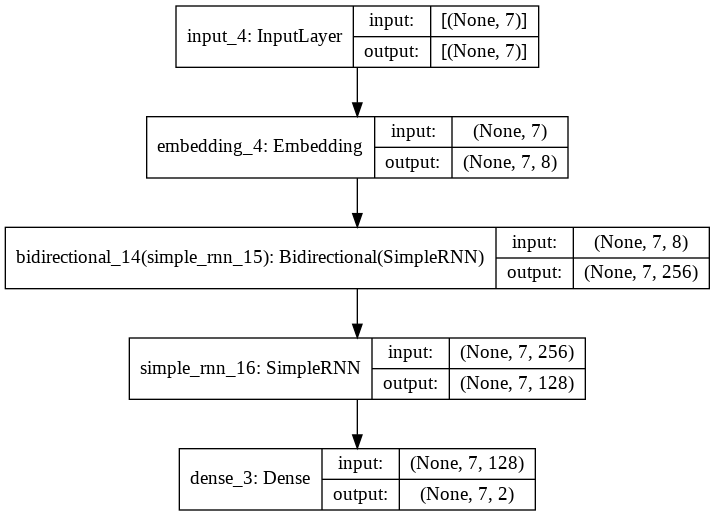

In [78]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [79]:
model.predict(train_inputs)

array([[[0.49770272, 0.5022972 ],
        [0.49543196, 0.50456804],
        [0.518626  , 0.481374  ],
        [0.49728534, 0.5027147 ],
        [0.49079457, 0.5092054 ],
        [0.49628597, 0.503714  ],
        [0.4656804 , 0.53431964]]], dtype=float32)